In [ ]:
%matplotlib inline
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import glob
import os

# --- Simulation Parameters (MUST MATCH YOUR C++ CODE) ---
NUM_SYSTEMS = 24
PARTICLES_PER_SYSTEM = 2048
TOTAL_PARTICLES = NUM_SYSTEMS * PARTICLES_PER_SYSTEM
BOX_MIN = -1.0
BOX_MAX = 1.0
SYSTEM_TO_PLOT = 0

particle_dtype = np.dtype([
    ('position', np.float32, 2),
    ('velocity', np.float32, 2),
    ('acceleration', np.float32, 2)
])

files = glob.glob("build/dat/*_step.bin")
if not files:
    print("Error: No .bin files found in the 'dat' directory.")
    exit()

def get_step_from_filename(f):
    basename = os.path.basename(f)
    return int(basename.split('_')[0])

files.sort(key=get_step_from_filename)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(BOX_MIN, BOX_MAX)
ax.set_ylim(BOX_MIN, BOX_MAX)
ax.set_aspect('equal')

scatter = ax.scatter([], [], s=5, c=[], cmap='gist_ncar')  # color by velocity

def update(frame_num):
    filename = files[frame_num]
    flat_data = np.fromfile(filename, dtype=particle_dtype)
    structured_data = flat_data.reshape((NUM_SYSTEMS, PARTICLES_PER_SYSTEM))
    positions = structured_data[SYSTEM_TO_PLOT]['position']
    velocities = structured_data[SYSTEM_TO_PLOT]['acceleration']

    # Compute color from velocity vector
    speed = np.linalg.norm(velocities, axis=1)
    # Normalize speed to [0, 1]
    speed_norm = (speed - speed.min()) / (speed.max() - speed.min() + 1e-8)

    scatter.set_offsets(positions)
    scatter.set_array(speed_norm)  # update color data

    step_num = get_step_from_filename(filename)
    ax.set_title(f"Particle Simulation (System {SYSTEM_TO_PLOT}, Step {step_num})")

    return scatter,

ani = FuncAnimation(fig, update, frames=len(files), blit=True, interval=50)
HTML(ani.to_jshtml())


/tmp/ipykernel_79003/3291035356.py:82: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  theory /= np.trapz(theory, centers)  # normalize area to 1
/tmp/ipykernel_79003/3291035356.py:82: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  theory /= np.trapz(theory, centers)  # normalize area to 1


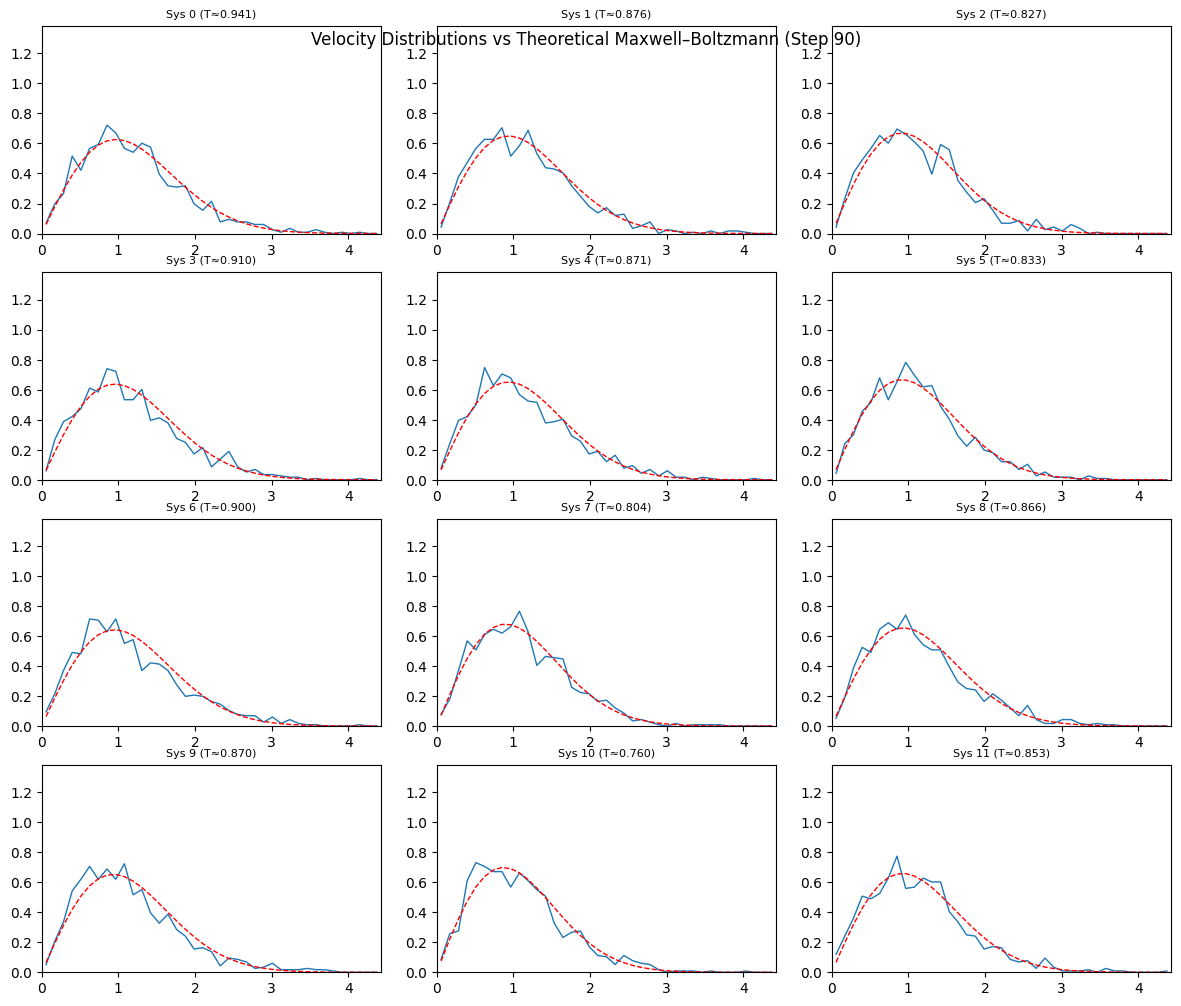

In [ ]:
%matplotlib inline
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import glob, os



# Note : We assume the integrator to conserve energy (looking at you Euler!)
# As such, the velocity distribution should remain constant over time.
# Thus, we only read the first frame to determine plotting ranges.

# --- Read first frame to determine ranges ---
flat = np.fromfile(files[0], dtype=particle_dtype)
structured = flat.reshape((NUM_SYSTEMS, PARTICLES_PER_SYSTEM))
all_speeds = np.linalg.norm(structured['velocity'], axis=2).flatten()

a = np.max(all_speeds) * 1.1  # 10% margin
bins = np.linspace(0, a, 40)

# estimate max density for y-limit
hist, _ = np.histogram(all_speeds, bins=bins, density=True)
b = np.max(hist) * 1.2  # 20% margin






# --- Theoretical Maxwell-Boltzmann distribution (2D) ---
def maxwell_boltzmann_2d(v, T):
    # normalized for 2D velocities: f(v) = (v/T)*exp(-v²/(2T))
    return (v / T) * np.exp(-v**2 / (2 * T))

# --- Plot grid (4x3 = 12 systems) ---
systems_per_page = 12
nrows, ncols = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10))
axes = axes.flatten()

bins = np.linspace(0, a, 40)
lines_hist = []
lines_theory = []

for ax in axes:
    hist_line, = ax.plot([], [], lw=1)
    theory_line, = ax.plot([], [], 'r--', lw=1)
    lines_hist.append(hist_line)
    lines_theory.append(theory_line)
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)
    # ax.set_xticks([])
    # ax.set_yticks([])

fig.tight_layout()

def update(frame_idx):
    filename = files[frame_idx]
    flat = np.fromfile(filename, dtype=particle_dtype)
    structured = flat.reshape((NUM_SYSTEMS, PARTICLES_PER_SYSTEM))

    offset = 0  # display systems 0–11
    for i in range(systems_per_page):
        sys_idx = offset + i
        if sys_idx >= NUM_SYSTEMS:
            lines_hist[i].set_data([], [])
            lines_theory[i].set_data([], [])
            continue

        vels = structured[sys_idx]['velocity']
        speeds = np.linalg.norm(vels, axis=1)

        # empirical histogram
        hist, edges = np.histogram(speeds, bins=bins, density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        lines_hist[i].set_data(centers, hist)

        # compute "temperature" from kinetic energy per particle
        T = np.mean(speeds**2) / 2.0
        theory = maxwell_boltzmann_2d(centers, T)
        theory /= np.trapz(theory, centers)  # normalize area to 1
        lines_theory[i].set_data(centers, theory)

        axes[i].set_title(f"Sys {sys_idx} (T≈{T:.3f})", fontsize=8)

    step = get_step_from_filename(filename)
    fig.suptitle(f"Velocity Distributions vs Theoretical Maxwell–Boltzmann (Step {step})", fontsize=12)
    return lines_hist + lines_theory

ani = FuncAnimation(fig, update, frames=len(files), blit=True, interval=50)
HTML(ani.to_jshtml())


Data processing complete.


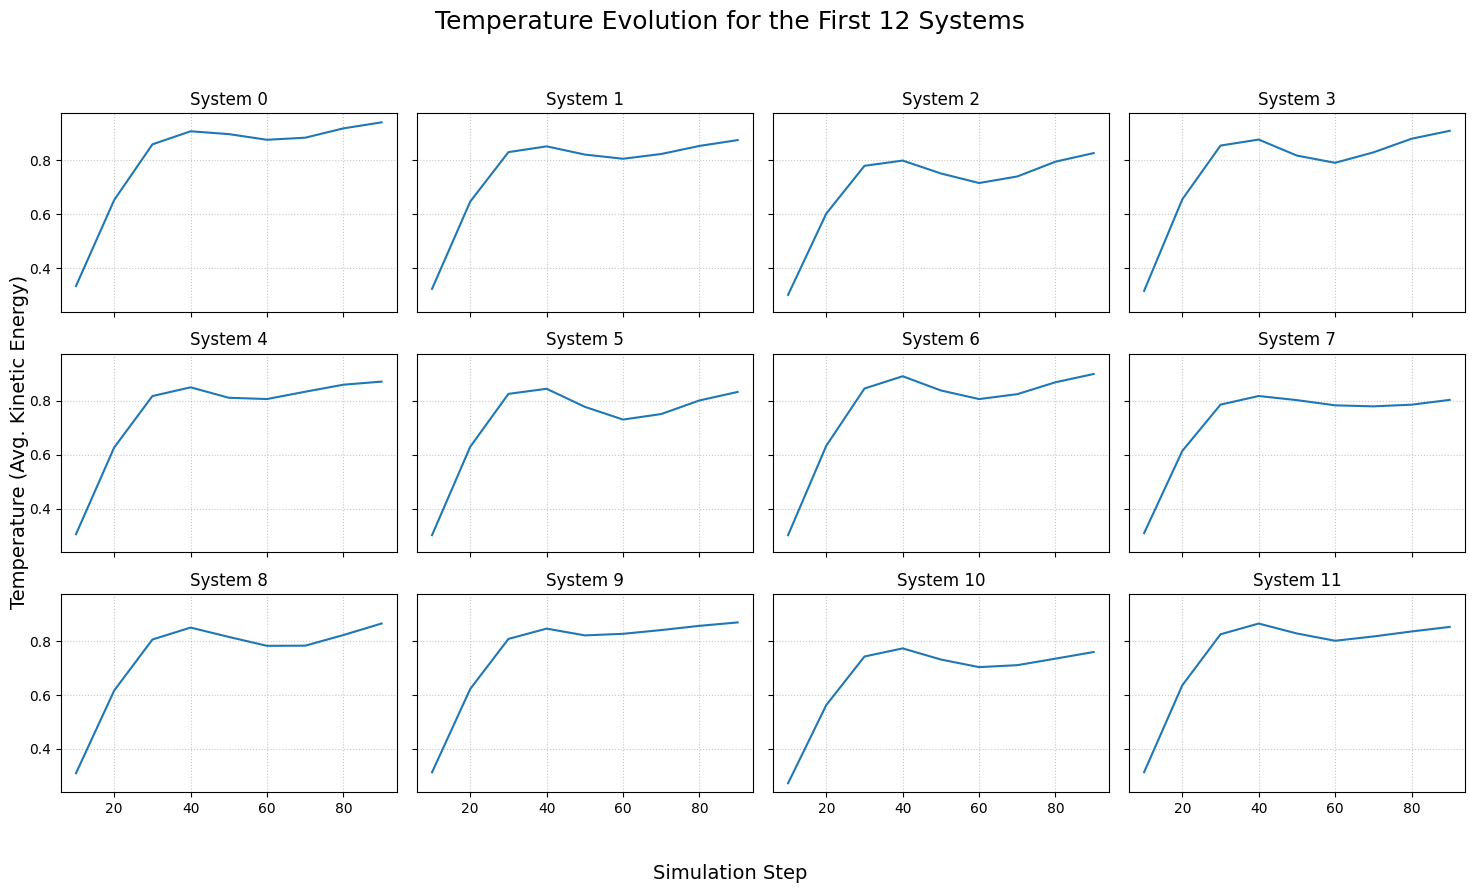

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


num_frames = len(files)
temperatures = np.zeros((num_frames, NUM_SYSTEMS))
steps = np.zeros(num_frames, dtype=int)

for i, filename in enumerate(files):
    steps[i] = get_step_from_filename(filename)
    flat_data = np.fromfile(filename, dtype=particle_dtype)
    if flat_data.size == 0: 
        print(f"Warning: File '{filename}' is empty, skipping.")
        continue
    
    structured_data = flat_data.reshape((NUM_SYSTEMS, PARTICLES_PER_SYSTEM))
    vels = structured_data['velocity']
    speeds_sq = np.sum(vels**2, axis=2)
    kinetic_energies = 0.5 * speeds_sq # Assuming mass = 1.0 for all particles
    temperatures[i, :] = np.mean(kinetic_energies, axis=1)

print("Data processing complete.")

# --- 2. Create the static 3x4 plot grid ---
systems_to_plot = 12
nrows, ncols = 3, 4
# Create subplots with shared X and Y axes for easy comparison
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# --- 3. Plot the full time series for each system ---
for i in range(systems_to_plot):
    ax = axes[i]
    # Plot the temperature history for the i-th system
    ax.plot(steps, temperatures[:, i], lw=1.5, label=f'System {i}')
    ax.set_title(f"System {i}", fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.7)

# --- 4. Final Formatting ---
fig.suptitle('Temperature Evolution for the First 12 Systems', fontsize=18)
# Add shared labels to the entire figure
fig.supxlabel("Simulation Step", fontsize=14)
fig.supylabel("Temperature (Avg. Kinetic Energy)", fontsize=14)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the final plot
plt.show()

Found 99 data files. Calculating MSE and RMSE for each frame...
Calculation complete.


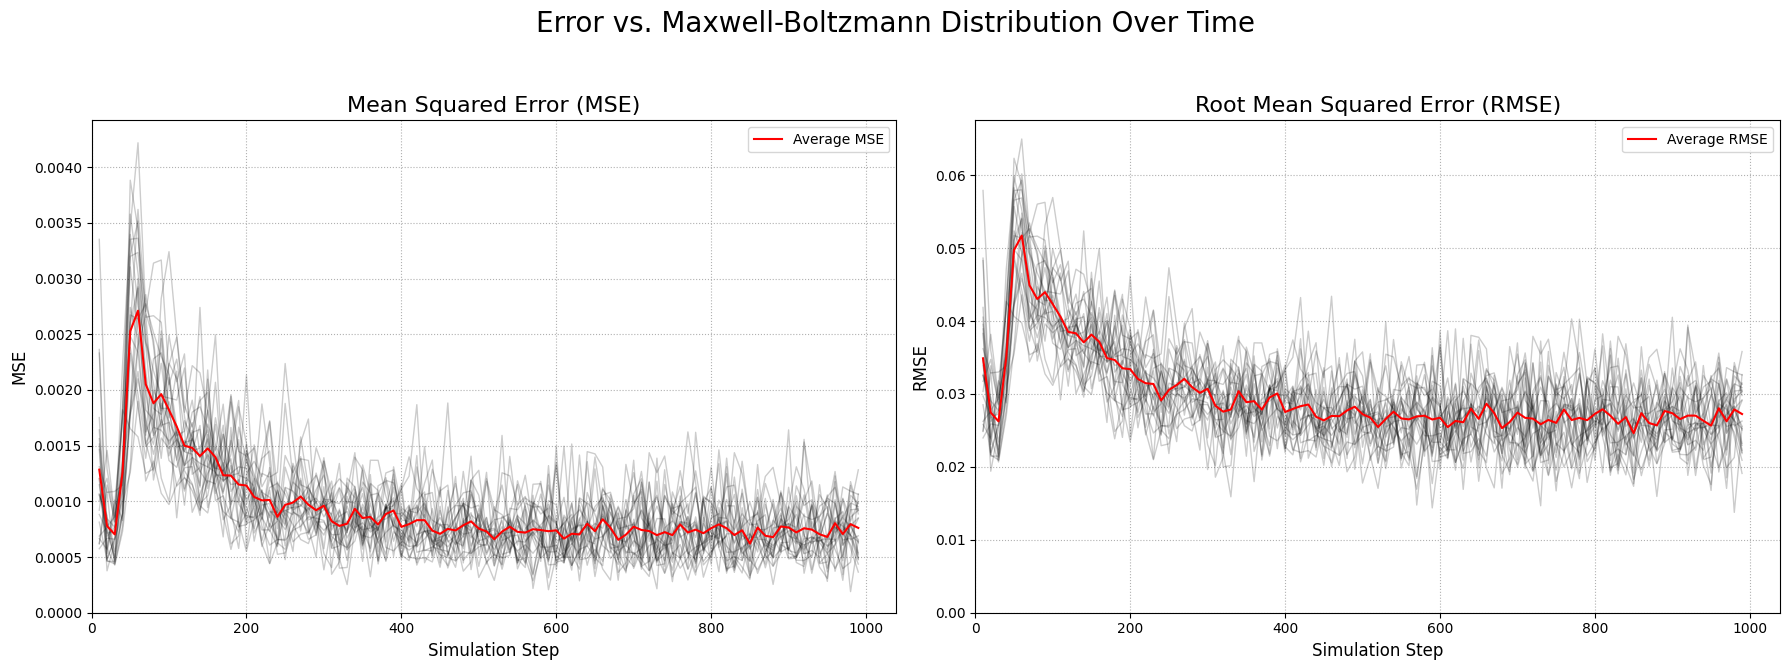

In [ ]:

files.sort(key=get_step_from_filename)
print(f"Found {len(files)} data files. Calculating MSE and RMSE for each frame...")

# --- 2. Pre-calculate histogram bins for consistency ---
# Use the first frame to establish a reasonable, fixed range for the histograms.
first_frame_data = np.fromfile(files[0], dtype=particle_dtype)
structured_first = first_frame_data.reshape((NUM_SYSTEMS, PARTICLES_PER_SYSTEM))
all_speeds_initial = np.linalg.norm(structured_first['velocity'], axis=2).flatten()
max_initial_speed = np.max(all_speeds_initial)
# Create fixed bins that will be used for every frame
bins = np.linspace(0, max_initial_speed * 1.5, 50) # Use 50 bins, with a 50% margin
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# --- 3. Load all data and calculate errors over time ---
num_frames = len(files)
all_mse = np.zeros((num_frames, NUM_SYSTEMS))
all_rmse = np.zeros((num_frames, NUM_SYSTEMS))
steps = np.zeros(num_frames, dtype=int)

for i, filename in enumerate(files):
    steps[i] = get_step_from_filename(filename)
    flat_data = np.fromfile(filename, dtype=particle_dtype)
    if flat_data.size == 0: continue
    
    structured_data = flat_data.reshape((NUM_SYSTEMS, PARTICLES_PER_SYSTEM))

    # Calculate error for each system in this frame
    for sys_idx in range(NUM_SYSTEMS):
        vels = structured_data[sys_idx]['velocity']
        speeds = np.linalg.norm(vels, axis=1)

        # a) Get the empirical distribution from the simulation
        hist_sim, _ = np.histogram(speeds, bins=bins, density=True)

        # b) Calculate the theoretical distribution
        # Temperature (T) in 2D is the average kinetic energy per particle
        T = np.mean(0.5 * np.sum(vels**2, axis=1)) # Assuming mass=1
        hist_theory = maxwell_boltzmann_2d(bin_centers, T)
        
        # c) Calculate the Mean Squared Error
        mse = np.mean((hist_sim - hist_theory)**2)
        
        # d) Store results
        all_mse[i, sys_idx] = mse
        all_rmse[i, sys_idx] = np.sqrt(mse)
        
print("Calculation complete.")

# --- 4. Calculate the average error across all systems ---
mean_mse = np.mean(all_mse, axis=1)
mean_rmse = np.mean(all_rmse, axis=1)

# --- 5. Create the 1x2 static plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- Left Plot: Mean Squared Error (MSE) ---
for i in range(NUM_SYSTEMS):
    ax1.plot(steps, all_mse[:, i], color='black', alpha=0.2, lw=1)
ax1.plot(steps, mean_mse, color='red', lw=1.5, label='Average MSE')
ax1.set_title('Mean Squared Error (MSE)', fontsize=16)
ax1.set_xlabel('Simulation Step', fontsize=12)
ax1.set_ylabel('MSE', fontsize=12)
ax1.legend()
ax1.grid(True, linestyle=':')
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)

# --- Right Plot: Root Mean Squared Error (RMSE) ---
for i in range(NUM_SYSTEMS):
    ax2.plot(steps, all_rmse[:, i], color='black', alpha=0.2, lw=1)
ax2.plot(steps, mean_rmse, color='red', lw=1.5, label='Average RMSE')
ax2.set_title('Root Mean Squared Error (RMSE)', fontsize=16)
ax2.set_xlabel('Simulation Step', fontsize=12)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.legend()
ax2.grid(True, linestyle=':')
ax2.set_xlim(left=0)
ax2.set_ylim(bottom=0)

# --- Final Formatting ---
fig.suptitle('Error vs. Maxwell-Boltzmann Distribution Over Time', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()